In [4]:
%matplotlib inline
import os, sys
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import torch
import torchvision
import flownet as fl
import goes16s3
import utils
from datetime import datetime
import xarray as xr
import scipy
import math
import time

font = {'family' : 'times',
        'size'   : 16}

matplotlib.rc('font', **font)

/home/tj/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_models(n_channels, model_path, multivariate=False):
    
    if multivariate:
        model_filename = os.path.join(model_path, 'checkpoint.flownet.mv.pth.tar')
        flownet = fl.SloMoFlowNetMV(n_channels)#.cuda()
        interpnet = fl.SloMoInterpNetMV(n_channels)#.cuda()
    else:
        model_filename = os.path.join(model_path, 'checkpoint.flownet.pth.tar')
        flownet = fl.SloMoFlowNet(n_channels)#.cuda()
        interpnet = fl.SloMoInterpNet(n_channels)#.cuda()
        
    warper = fl.FlowWarper()
    
    flownet = flownet.to(device)
    interpnet = interpnet.to(device)
    warper = warper.to(device)

    def load_checkpoint(flownet, interpnet):
        epoch = 0
        if os.path.isfile(model_filename):
            print("loading checkpoint %s" % model_filename)
            checkpoint = torch.load(model_filename)
            flownet.load_state_dict(checkpoint['flownet_state_dict'])
            interpnet.load_state_dict(checkpoint['interpnet_state_dict'])
            epoch = checkpoint['epoch']
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(model_filename, epoch))
        else:
            print("=> no checkpoint found at '{}'".format(model_filename))
        return flownet, interpnet

    flownet.train()
    interpnet.train()
    flownet, interpnet = load_checkpoint(flownet, interpnet)
    return flownet, interpnet, warper

def block_predictions_to_dataarray(predictions, block):
    block_predictions = np.concatenate(predictions, 0)
    block_predictions[block_predictions < 0] = 0
    block_predictions[block_predictions > 1] = 1

    N_pred = block_predictions.shape[0]
    T = np.arange(0,N_pred)
    da = xr.DataArray(block_predictions,#[:,:,shave:-shave,shave:-shave],
              coords=[T, block.band.values,
                      block.y.values,#[shave:-shave], 
                      block.x.values,],#][shave:-shave]],
              dims=['t', 'band', 'y', 'x'])

    return da

def inference_5min(block, flownet, interpnet, warper, multivariate, T=4):
    block_vals = torch.from_numpy(block.values)
    block_vals[np.isnan(block_vals)] = 0
    n_channels = block_vals.shape[1]
    N = block_vals.shape[0]
    idxs = np.arange(0, N)
    preds = []
    for idx0, idx1 in zip(idxs[:-1], idxs[1:]):
        idx1 = min(N-1, idx1)
        I0 = torch.unsqueeze(block_vals[idx0], 0).to(device)
        I1 = torch.unsqueeze(block_vals[idx1], 0).to(device)

        f = flownet(I0, I1)
        n_channels = I0.shape[1]
        
        if multivariate:
            f_01 = f[:,:2*n_channels]
            f_10 = f[:,2*n_channels:]
        else:
            f_01 = f[:,:2]
            f_10 = f[:,2:]

        predicted_frames = []
        for j in range(1,T+1):
            t = 1. * j / (T+1)
            I_t, g0, g1, V_t0, V_t1, delta_f_t0, delta_f_t1 = interpnet(I0, I1, f_01, f_10, t)
            predicted_frames.append(I_t.cpu().detach().numpy())
        
        preds += [I0.cpu().numpy()] + predicted_frames
    del f_01, f_10, f, I_t, g0, g1, V_t0, V_t1, delta_f_t0, delta_f_t1
    torch.cuda.empty_cache()
    return block_predictions_to_dataarray(preds, block)

def merge_and_average_dataarrays(dataarrays):
    ds = xr.merge([xr.Dataset({k: d}) for k, d in enumerate(dataarrays)])
    das = []
    for b in range(0,len(dataarrays)):
        das.append(ds[b])

    return xr.concat(das).mean('concat_dims', skipna=True)



In [6]:
model_path = './saved-models/5Min-3Channels/'
flownet, interpnet, warper = load_models(3, model_path, False)
dataset = goes16s3.NOAAGOESS3(product='ABI-L1b-RadC', 
                              channels=range(1,4))
year = 2018
day = 198
n_channels = 3
for houri, hour_das in enumerate(dataset.read_day(year, day, hours=[18])):
    print(houri, hour_das)
    break


loading checkpoint ./saved-models/5Min-3Channels/checkpoint.flownet.pth.tar
=> loaded checkpoint './saved-models/5Min-3Channels/checkpoint.flownet.pth.tar' (epoch 19)
('Day', 198, 'Hour', 18)
(0, <xarray.DataArray (t: 12, band: 3, y: 1500, x: 2500)>
array([[[[     nan, ..., 0.410806],
         ...,
         [0.070868, ..., 0.054744]],

        ...,

        [[     nan, ..., 0.430072],
         ...,
         [0.031449, ..., 0.042556]]],


       ...,


       [[[     nan, ..., 0.274214],
         ...,
         [0.073702, ..., 0.071046]],

        ...,

        [[     nan, ..., 0.24415 ],
         ...,
         [0.035504, ..., 0.066188]]]], dtype=float32)
Coordinates:
  * y        (y) float64 0.1282 0.1282 0.1281 0.1281 ... 0.04442 0.04437 0.04431
  * x        (x) float64 -0.1013 -0.1013 -0.1012 ... 0.03846 0.03851 0.03857
  * band     (band) int64 1 2 3
    y_image  float32 0.08624
    x_image  float32 -0.03136
  * t        (t) datetime64[ns] 2018-07-17T18:03:46.378832 ... 2018-07-17T18

/home/tj/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


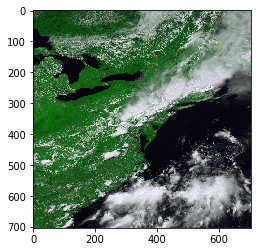

In [7]:
fivemin_das = hour_das.isel(t=range(0,1))
blocked_data = utils.blocks(fivemin_das, width=2*352)

block_vals = torch.from_numpy(blocked_data[2].values)
block_vals[np.isnan(block_vals)] = 0

arr = block_vals[0]
arr = np.transpose(arr, (1,2,0))
plt.imshow(arr[:,:,[1,2,0]])
plt.show()

In [11]:
year = 2018
day = 198
n_channels = 3    
frame_counter = 0
for houri, hour_das in enumerate(dataset.read_day(year, day, hours=range(12,20))):
    print("Hour {}".format(houri))
    for it in range(1,hour_das.t.shape[0]):
        torch.cuda.empty_cache()
        fivemin_das = hour_das.isel(t=range(it-1,it+1))
        blocked_data = utils.blocks(fivemin_das, width=352)
        sv_interpolated_hour = []
        t=time.time()
        #for block_num, block in enumerate(blocked_data):       
        block = blocked_data[4]
        sv_da = inference_5min(block, flownet, interpnet, warper, False, T=59)
        sv_interpolated_hour.append(sv_da)
        sv_prediction_da = merge_and_average_dataarrays(sv_interpolated_hour)
        print("Time to interpolate and merge 5 minutes of CONUS: {}".format(time.time() - t))

        for tidx in range(sv_prediction_da.t.shape[0]):
            img0 = sv_prediction_da.isel(t=0).values
            img0 = np.transpose(img0, (1,2,0))[126:,126:]
            img1 = sv_prediction_da.isel(t=tidx).values
            img1 = np.transpose(img1, (1,2,0))[126:,126:]

            img = np.concatenate([img0, img1], axis=1)[::-1,:,[1,2,0]]
            plt.imsave('./video-images-126/img-%04i.png' % frame_counter, img)
            frame_counter += 1


('Day', 198, 'Hour', 12)
Hour 0


/home/tj/.local/lib/python2.7/site-packages/ipykernel_launcher.py:93: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'


Time to interpolate and merge 5 minutes of CONUS: 0.792526960373
Time to interpolate and merge 5 minutes of CONUS: 0.752654075623
Time to interpolate and merge 5 minutes of CONUS: 0.756833076477
Time to interpolate and merge 5 minutes of CONUS: 0.749816179276
Time to interpolate and merge 5 minutes of CONUS: 0.782387018204
Time to interpolate and merge 5 minutes of CONUS: 0.748760938644
Time to interpolate and merge 5 minutes of CONUS: 0.754854917526
Time to interpolate and merge 5 minutes of CONUS: 0.756105899811
Time to interpolate and merge 5 minutes of CONUS: 0.746896028519
Time to interpolate and merge 5 minutes of CONUS: 0.753579854965
Time to interpolate and merge 5 minutes of CONUS: 0.750537157059
('Day', 198, 'Hour', 13)
Hour 1
Time to interpolate and merge 5 minutes of CONUS: 0.799981117249
Time to interpolate and merge 5 minutes of CONUS: 0.755552053452
Time to interpolate and merge 5 minutes of CONUS: 0.754631996155
Time to interpolate and merge 5 minutes of CONUS: 0.759603

KeyboardInterrupt: 

In [3]:
cmd = 'ffmpeg -r 24 -i video-images/img-%04d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p conus-30sec.mp4'
os.system(cmd)

NameError: name 'os' is not defined